In [3]:
import random 
import cv2 
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
# from kd_export import LightNN
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:
# Lightweight neural network class to be used as student:
class LightNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 56 * 56, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [5]:
def add_noise(img): 
    # Getting the dimensions of the image 
    row , col = img.shape 
      
    # Randomly pick some pixels in the 
    # image for coloring them white 
    # Pick a random number between 300 and 10000 
    number_of_pixels = random.randint(300, 10000) 
    for i in range(number_of_pixels): 
        
        # Pick a random y coordinate 
        y_coord=random.randint(0, row - 1) 
          
        # Pick a random x coordinate 
        x_coord=random.randint(0, col - 1) 
          
        # Color that pixel to white 
        img[y_coord][x_coord] = 255
          
    # Randomly pick some pixels in 
    # the image for coloring them black 
    # Pick a random number between 300 and 10000 
    number_of_pixels = random.randint(300 , 10000) 
    for i in range(number_of_pixels): 
        
        # Pick a random y coordinate 
        y_coord=random.randint(0, row - 1) 
          
        # Pick a random x coordinate 
        x_coord=random.randint(0, col - 1) 
          
        # Color that pixel to black 
        img[y_coord][x_coord] = 0
          
    return img 

In [6]:
base_origin = "./mvtec_dataset"

base_dir = "organized_test"
store_dir = "noise_test"

test_output_path = os.path.join(base_origin, base_dir)
noise_output_path = os.path.join(base_origin, store_dir)

os.makedirs(noise_output_path, exist_ok=True)

# Dictionary to store images
images = {}

# Loop through each folder
for folder_name in os.listdir(test_output_path):
    folder_path = os.path.join(test_output_path, folder_name)
    save_path = os.path.join(noise_output_path, folder_name)

    os.makedirs(save_path, exist_ok=True)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            file_save = os.path.join(save_path, file_name)
            
            # Check if it's an image file (optional)
            if file_name.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                img = cv2.imread(file_path, 
                                cv2.IMREAD_GRAYSCALE) 
                
                #Storing the image 
                cv2.imwrite(file_save, 
                            add_noise(img)) 

# Close all OpenCV windows (if used)
cv2.destroyAllWindows()


In [7]:
# List of tools
tools = [
    "bottle", "cable", "capsule", "carpet", "grid", "hazelnut", "leather", "metal_nut",
    "pill", "screw", "tile", "toothbrush", "transistor", "wood", "zipper"
]

classes = sorted(tools)
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

class FixedImageFolder(ImageFolder):
    def __init__(self, root, transform, class_to_idx):
        self.class_to_idx = class_to_idx
        self.classes = list(class_to_idx.keys())
        super().__init__(root, transform=transform)
        self.imgs = self.samples

    def find_classes(self, directory):
        return self.classes, self.class_to_idx
    
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

noise_dataset = FixedImageFolder(
    root=noise_output_path,
    transform=val_test_transforms,
    class_to_idx=class_to_idx
)
noiseloader = DataLoader(noise_dataset, batch_size=32, shuffle=False, num_workers=0)

In [8]:
print("Check current device: ")
# Check if GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available(): # Should return True 
    print(f"Using GPU: {torch.cuda.get_device_name(0)}") # Should show your GPU name
else:
    print("Using CPU")

Check current device: 
Using GPU: NVIDIA GeForce RTX 4060


In [9]:
pretrained_model = "student_model.pth"
pretrained_model_KD = "student_model_KD.pth"
use_cuda=True

In [10]:
# Initialize the network
torch.manual_seed(42)
model = LightNN(num_classes=15).to(device)
torch.manual_seed(42)
model_KD = LightNN(num_classes=15).to(device)


# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location=device, weights_only=True))
model_KD.load_state_dict(torch.load(pretrained_model_KD, map_location=device, weights_only=True))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()
model_KD.eval()

LightNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=50176, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=15, bias=True)
  )
)

In [17]:
def test(model, testloader, device):
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
	
            # Collect predictions and true labels
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics using sklearn
    cm = confusion_matrix(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, output_dict=True, zero_division=0)

    return cm, report

In [18]:
accuracies = []
examples = []

# Run noise dataset for each epsilon
test_light_noise = test(model, noiseloader, device)
test_accuracy_light_noise = test_light_noise[1]["accuracy"] * 100
precision_light_noise = test_light_noise[1]["weighted avg"]["precision"]
recall_light_noise = test_light_noise[1]["weighted avg"]["recall"]
f1_light_noise = test_light_noise[1]["weighted avg"]["f1-score"]

# Compare the student test accuracy with and without the teacher, after distillation
# print("-----------------------------------------")
# print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
# print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")

print("-----------------------------------------")
print(f"Student accuracy with CE + KD:")
print(f"Accuracy: {test_accuracy_light_noise:.2f}%")
# Print other value metrics:
print(f"Precision: {precision_light_noise:.2f}")
print(f"Recall: {recall_light_noise:.2f}")
print(f"F1 Score: {f1_light_noise:.2f}")

-----------------------------------------
Student accuracy with CE + KD:
Accuracy: 89.51%
Precision: 0.90
Recall: 0.90
F1 Score: 0.86


<Figure size 800x600 with 0 Axes>

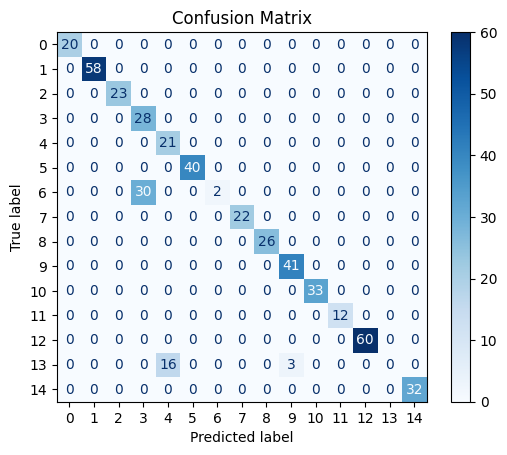

In [19]:
# Generate the confusion matrix
cm = test_light_noise[0]
# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()